Developed a real time Lanes detection mechanism using OpenCV for self-driving cars.

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [2]:
img = cv2.imread('/content/test_image.jpg')

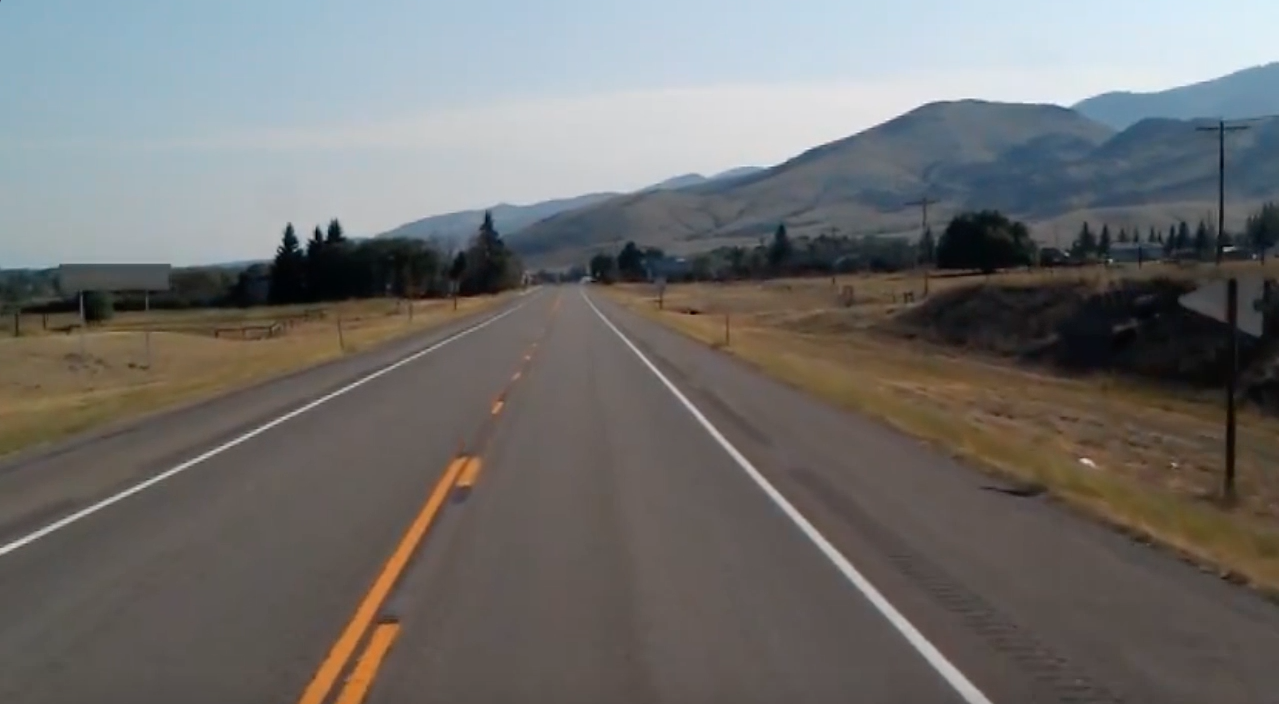

In [3]:
cv2_imshow(img)

In [4]:
cur_img = np.copy(img)                               # copying the image so that the future changes doesn't affect the original image

In [5]:
def canny(image):
  gray = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)     # converting the RGB original image (3 channels) to grayscaled image (1 channel) to reduce the computational intensity
  blur = cv2.GaussianBlur(gray, (5,5), 0)              # reduces noise in the image by blurring; we are using Gaussian blur here, by convolving the Gaussian kernel over the image, we convolve the pixels in such a way wherein the values surrounding a pixel get averaged
  canny = cv2.Canny(blur, 50, 150)                     # completely black areas correspond to low changes in intensity (below low_threshold) btw adj pixels (low gradient), white lines represent regions where there is a high change in intensity (above the high_threshold)
  return canny

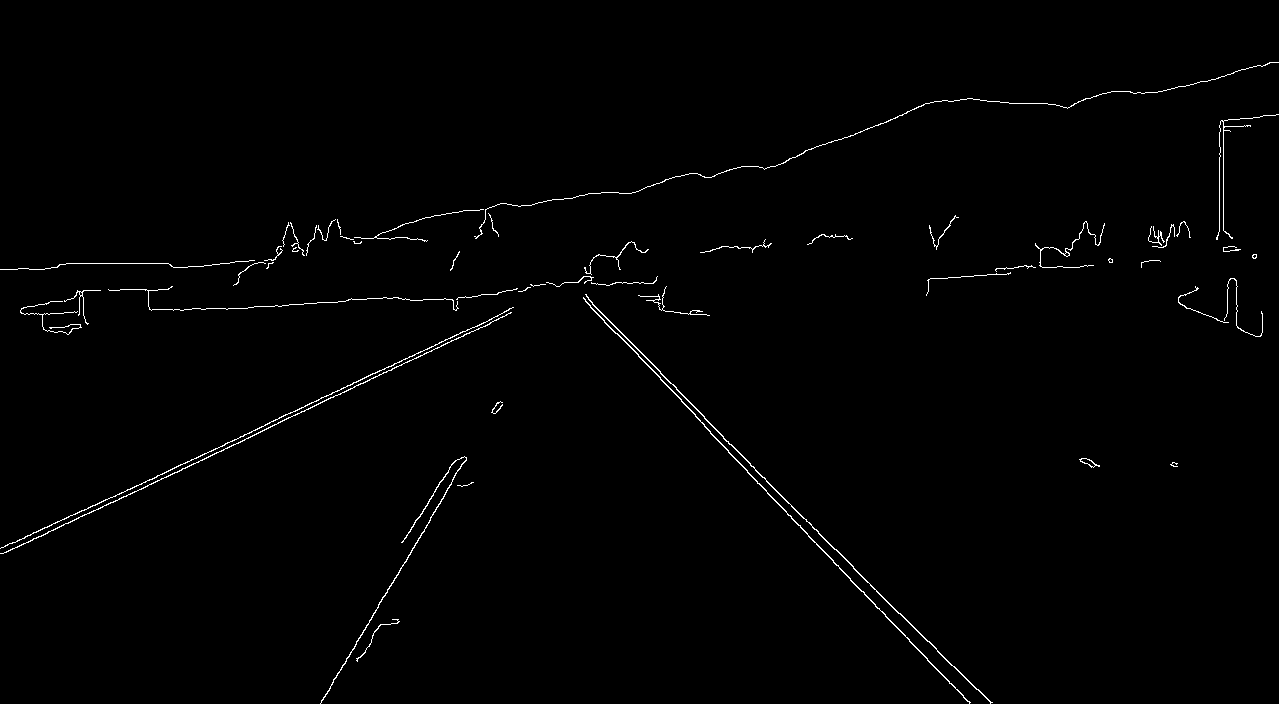

In [6]:
canny_image = canny(cur_img)
cv2_imshow(canny_image)                                 # canny_image now is a 2D image

In [7]:
import matplotlib.pyplot as plt

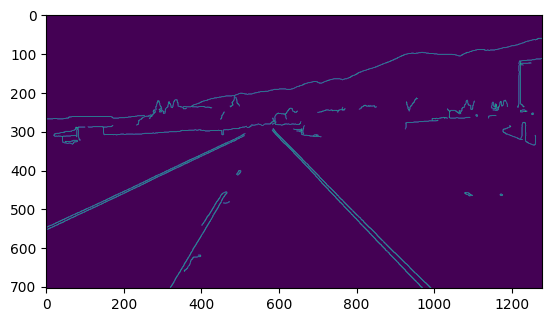

In [8]:
plt.imshow(canny_image)

In [9]:
def region_of_interest(image):
  height = image.shape[0]                                                                    # obtaining the height of the image = 700 pixels (along the y, axis)
  polygons = np.array([[(200, height), (1100, height), (550, 250)]])                       # just like the canny image (the output) which is a 2D image, we are defining a region of interest (2D) with all int type np.int32
  mask = np.zeros_like(image)                                                                # we obtain a black mask where we fill in all the values of the pixels (same as canny's dim) as 0 to obtain blackness
  cv2.fillPoly(mask, polygons, 255)                                                        # we fill the black mask with the white (255) polygon (triangle)
  masked_image = cv2.bitwise_and(image, mask)                                                # we create a masked image with white outlines by doing carrying on bitwise_and (with the mask filled with poly and the original canny image) which conserves the black binaries and comes out with only the white outlines
  return masked_image

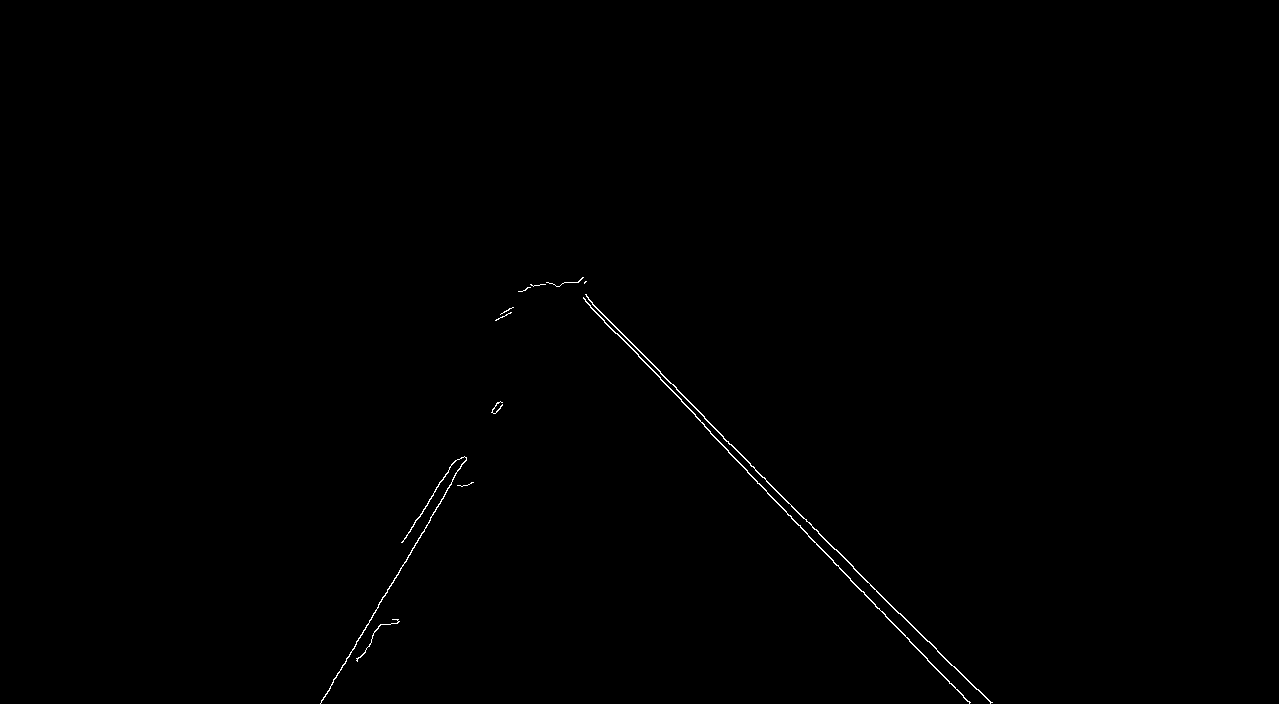

In [10]:
cropped_image = region_of_interest(canny_image)
cv2_imshow(cropped_image)

In [11]:
st_lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength = 40, maxLineGap = 5)          # a bin with 2 pixel precision and 1 radian precision; the smaller the bin, the more accurate capture of the intersecion of points on the rho vs theta graph (to find the st.lines)

In [ ]:
# every st. line is y = mx + b and hence line can be represented as a point (m,b) in the Hough Line space,
# multiple lines of different m and b can also pass thru this point
# we represent all these lines that can pass thru that point in the form of rho vs rad, and so we obtain a sinusoidal graph of all the possible lines
# all these sinusoidal graphs intersect at a point and this is exactly a point where a straight line is detected (since you've found the rho and theta from the point of intersection)
# we cannot detect vertical edge as m of vertical lines (i.e. tan 90 is infinity)
# we divide the Hough Line space into multiple grids/bins (the more you split --> the less pixel each small bin contributes to), and we set a threshold for the number of intersecting curves
# by threshold in the sense, if the number of intersecting curves is greater than or equal to 100 (in this case), we are going to be adding a vote to that particular bin

In [12]:
def display_st_lines(image, st_lines):
  line_image = np.zeros_like(image)
  if st_lines is not None:
    for line in st_lines:
      x1, y1, x2, y2 = line.reshape(4)     # 2D to 1D and unpacking the elements
      x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
      cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)   # BGR = (255, 0, 0) --> Blue and thickness of the line = 10 pixels
  combined_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)   # adding weights to the image's arrays to decrease its intensity to achieve darker lines, and then combining both the image as well as the lines
  return combined_image

In [13]:
cur_img_with_lines = display_st_lines(cur_img, st_lines)

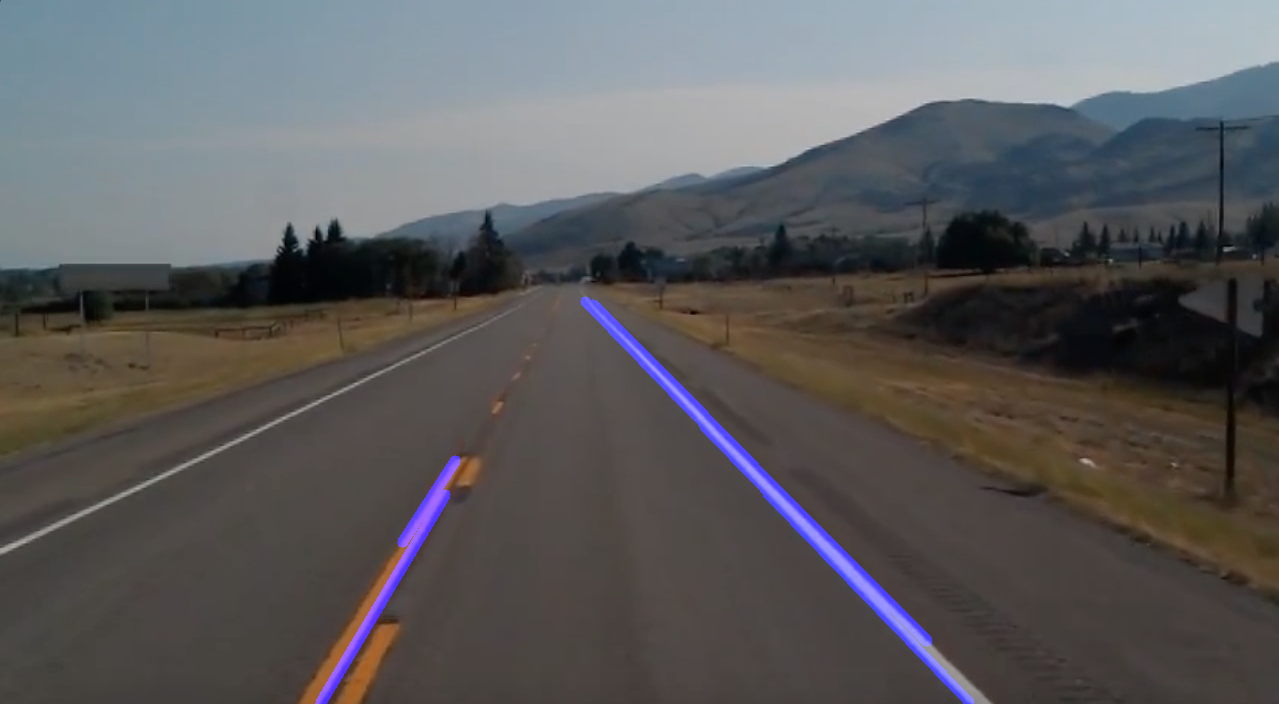

In [14]:
cv2_imshow(cur_img_with_lines)

In [15]:
def avg_slope_intercept(image, st_lines):   # to average out the slopes so that the lines are continuous (i.e. have the same slope approx.)
  left_fit = []
  right_fit = []
  for line in st_lines:
    x1, y1, x2, y2 = line.reshape(4)
    parameters = np.polyfit((x1, x2), (y1, y2), 1)   # fitting a polynomial of degree 1 thru those points --> returns 1D arrays of 2 elements where in the first element is the slope (m) and the second element is the y intercept (b)
    slope = parameters[0]
    y_intercept = parameters[1]
    # when looked at the blue lines in the combined image, the lines on the right have a +ve slope (dec. in pixels in x, dec. in pixels in y)
    # when looked at the blue lines in the combined image, the lines on the left have a -ve slope (inc. in pixels in x, dec. in pixels in y
    if slope < 0:
      left_fit.append((slope, y_intercept))  # appending as a tuple
    else:
      right_fit.append((slope, y_intercept))
  # print(left_fit)
  # print(right_fit)
  left_fit_avg = np.average(left_fit, axis = 0)   # averaged values of m and b for the left_fit
  right_fit_avg = np.average(right_fit, axis = 0)  # averaged values of m and b for the right_fit
  print(left_fit_avg)
  print(right_fit_avg)
  left_line = make_coordinates(cur_img, left_fit_avg)
  right_line = make_coordinates(cur_img, right_fit_avg)
  return np.array([left_line, right_line])

In [18]:
avg_slope_intercept(cur_img, st_lines)

[  -1.60958491 1201.00113208]
[   1.01768297 -294.90022687]


array([[308.77596474, 704.        , 483.97641487, 422.        ],
       [981.54362059, 704.        , 704.44357239, 422.        ]])

In [17]:
def make_coordinates(image, slope_and_intercept):  # making coordinates with slope and y intercept
  slope, intercept = slope_and_intercept
  y1 = image.shape[0]  # starting with the bottom
  y2 = int(y1 * (3/5))
  x1 = (y1 - intercept)/slope                     # y = mx + b --> x = (y-b)/m
  x2 = (y2 - intercept)/slope
  return np.array([x1, y1, x2, y2])

In [19]:
averaged_st_lines = avg_slope_intercept(cur_img, st_lines)

[  -1.60958491 1201.00113208]
[   1.01768297 -294.90022687]


In [20]:
cur_img_with_averaged_lines = display_st_lines(cur_img, averaged_st_lines)

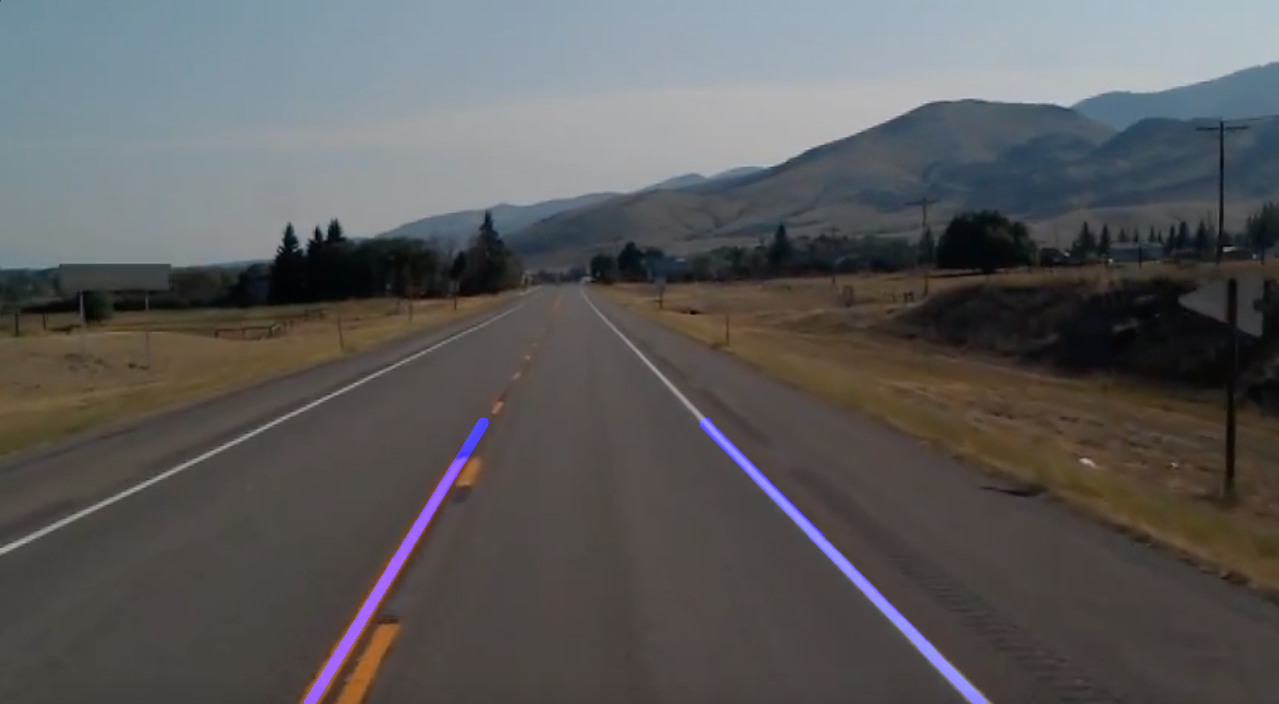

In [21]:
cv2_imshow(cur_img_with_averaged_lines)

In [22]:
from IPython.display import display, clear_output
import time

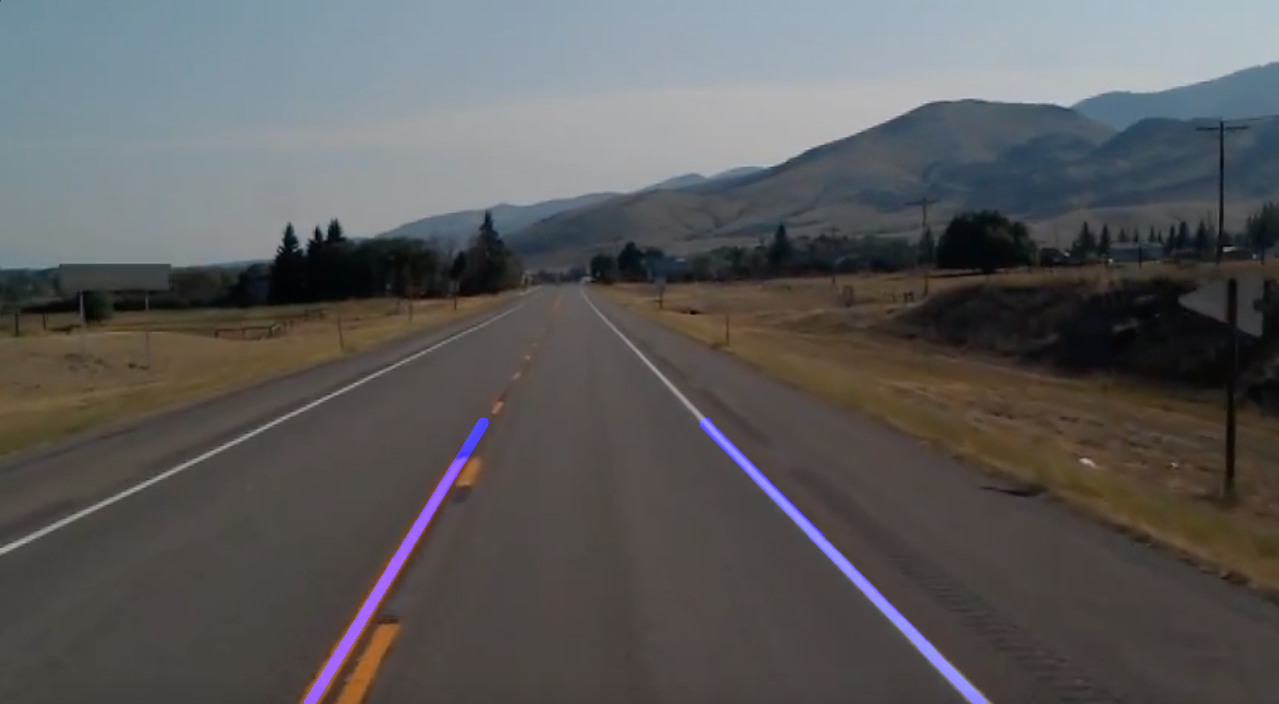

In [ ]:
cap = cv2.VideoCapture('/content/test2.mp4')
while cap.isOpened():
    ret, frame = cap.read() # reads every frame of the video and unpacks the 2 values that it returns as an output
    if not ret:
        break
    clear_output(wait=True) # Display the frame
    cv2_imshow(cur_img_with_averaged_lines)
    time.sleep(0.03) # Adds a slight delay to simulate video playback
cap.release()
cv2.destroyAllWindows()